# Import Libraries

In [1]:
import pandas as pd
import numpy as np
import math
pd.set_option('display.max_columns',None)
import re
import nltk
from bs4 import BeautifulSoup
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from sklearn.model_selection import train_test_split
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, precision_recall_curve, plot_precision_recall_curve
from pprint import pprint
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

Download necessary libraries

# Import Data

In [2]:
train_df = pd.read_csv("../data/Twitter/twitter_training.csv",header=None)
test_df = pd.read_csv("../data/Twitter/twitter_validation.csv",header=None)
train_df.head()

,0,1,2,3
0,2401,Borderlands,Positive,im getting on borderlands and i will murder yo...
1,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
2,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
3,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
4,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...


In [3]:
train_df.columns = ['i','topic','sentiment','tweet']
test_df.columns = ['i','topic','sentiment','tweet']
train_df.head()

,i,topic,sentiment,tweet
0,2401,Borderlands,Positive,im getting on borderlands and i will murder yo...
1,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
2,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
3,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
4,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...


# Data processing

In [4]:
train_df = train_df[train_df['sentiment']!='Irrelevant']
train_df = train_df.dropna()
test_df = test_df[test_df['sentiment']!='Irrelevant']
test_df = test_df.dropna()

# Dataset General Summary & Sentiment Distribution

In [5]:
train_df.shape, test_df.shape

((61121, 4), (828, 4))

In [6]:
train_df.sentiment.unique(), test_df.sentiment.unique()

(array(['Positive', 'Neutral', 'Negative'], dtype=object),
 array(['Neutral', 'Negative', 'Positive'], dtype=object))

In [7]:
train_df.groupby("sentiment").count(), test_df.groupby("sentiment").count()

(               i  topic  tweet
 sentiment                     
 Negative   22358  22358  22358
 Neutral    18108  18108  18108
 Positive   20655  20655  20655,
              i  topic  tweet
 sentiment                   
 Negative   266    266    266
 Neutral    285    285    285
 Positive   277    277    277)

Percentage

In [8]:
100*train_df.groupby("sentiment").count()[['tweet']]/train_df.shape[0],100*test_df.groupby("sentiment").count()[['tweet']]/test_df.shape[0]

(               tweet
 sentiment           
 Negative   36.579899
 Neutral    29.626479
 Positive   33.793622,
                tweet
 sentiment           
 Negative   32.125604
 Neutral    34.420290
 Positive   33.454106)

train & test dataset has similar distribution

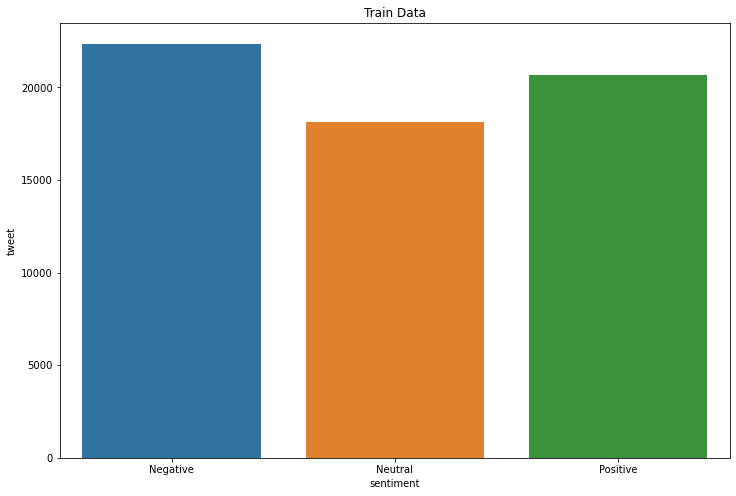

In [9]:
fig,ax = plt.subplots(figsize=(12,8))
sns.barplot(data=train_df.groupby('sentiment').count().reset_index(), x='sentiment', y='tweet',ax = ax)
plt.title("Train Data")
plt.show()
plt.close()

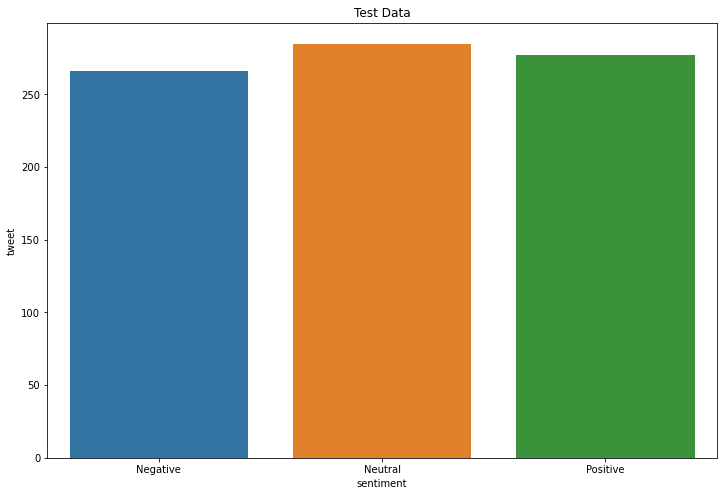

In [10]:
fig,ax = plt.subplots(figsize=(12,8))
sns.barplot(data=test_df.groupby('sentiment').count().reset_index(), x='sentiment', y='tweet',ax = ax)
plt.title("Test Data")
plt.show()
plt.close()

## Topic analysis

- bar graph of topic count
- multi bar graph of topic count & pos vs neg vs neutral

In [11]:
print("total number of topics: {}".format(train_df.topic.unique().shape[0]))

total number of topics: 32


In [12]:
train_df.groupby('topic').count()[['tweet']]

,tweet
topic,
Amazon,2090
ApexLegends,2161
AssassinsCreed,1970
Battlefield,1401
Borderlands,2040
CS-GO,1652
CallOfDuty,1704
CallOfDutyBlackopsColdWar,1774
Cyberpunk2077,1797


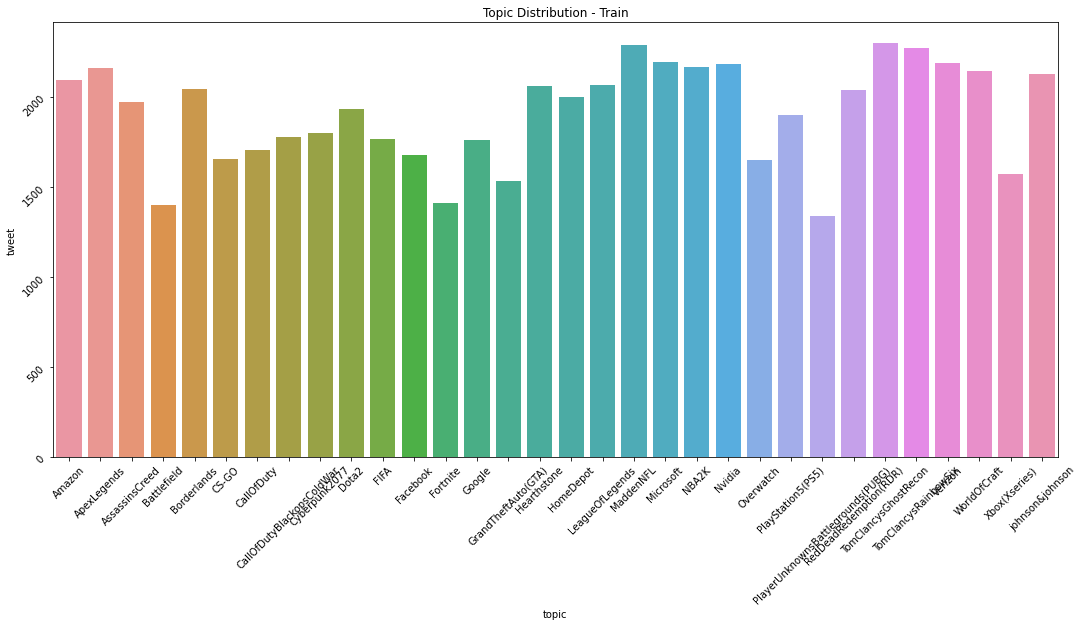

In [13]:
fig,ax = plt.subplots(figsize=(18,8))
sns.barplot(data=train_df.groupby('topic').count().reset_index(), x='topic', y='tweet',ax = ax)
plt.title("Topic Distribution - Train")
plt.xlabel("topic")
ax.tick_params(labelrotation=45)
plt.show()
plt.close()

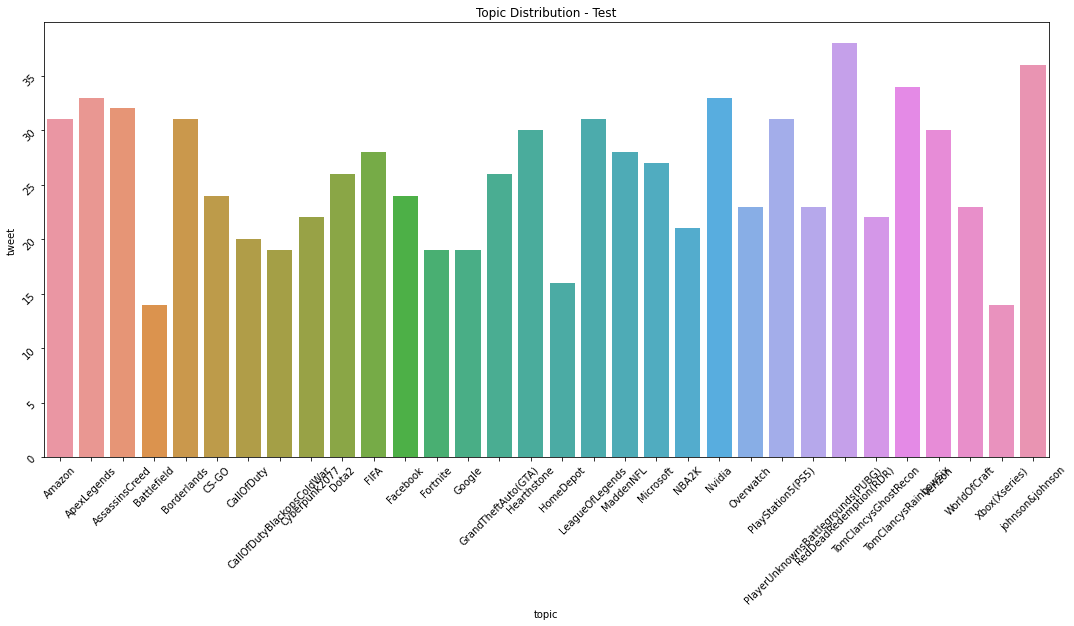

In [14]:
fig,ax = plt.subplots(figsize=(18,8))
sns.barplot(data=test_df.groupby('topic').count().reset_index(), x='topic', y='tweet',ax = ax)
plt.title("Topic Distribution - Test")
plt.xlabel("topic")
ax.tick_params(labelrotation=45)
plt.show()
plt.close()

# Topic distribution by sentiment

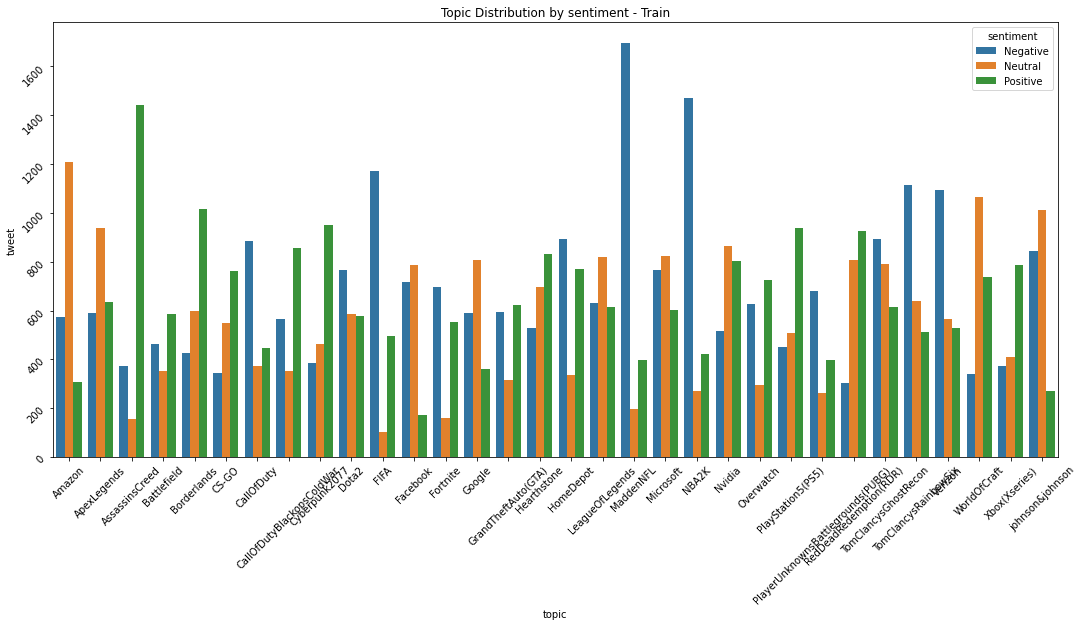

In [15]:
p_df = train_df.groupby(['topic','sentiment']).count().reset_index()
fig,ax = plt.subplots(figsize=(18,8))
sns.barplot(data=p_df, x='topic', y='tweet',hue='sentiment',ax = ax)
plt.title("Topic Distribution by sentiment - Train")
plt.xlabel("topic")
ax.tick_params(labelrotation=45)
plt.show()
plt.close()

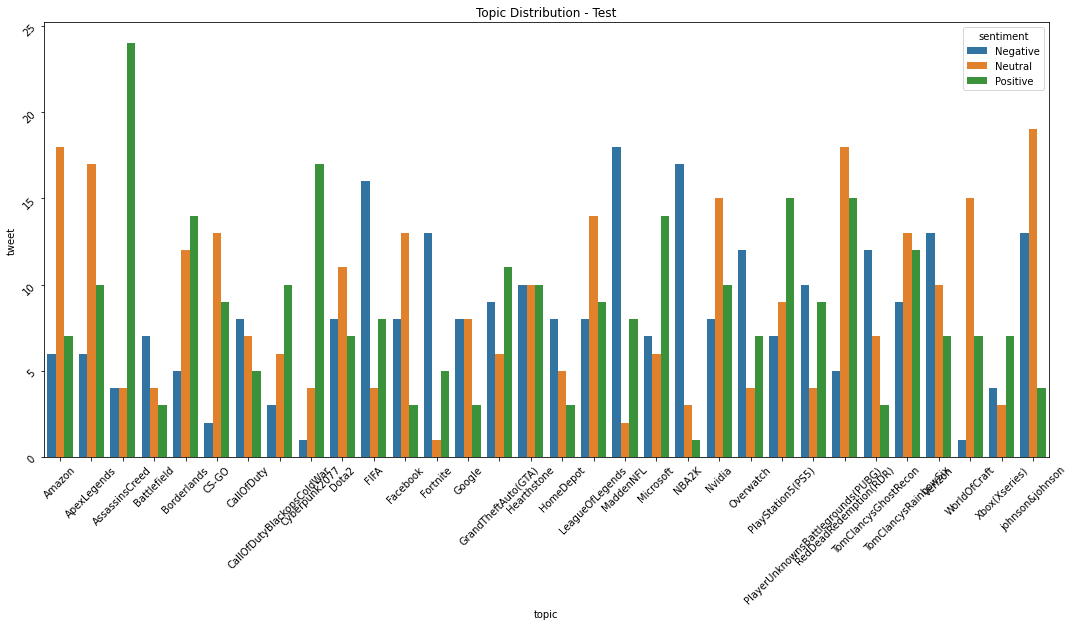

In [16]:
p_df = test_df.groupby(['topic','sentiment']).count().reset_index()
fig,ax = plt.subplots(figsize=(18,8))
sns.barplot(data=p_df, x='topic', y='tweet',hue='sentiment',ax = ax)
plt.title("Topic Distribution - Test")
plt.xlabel("topic")
ax.tick_params(labelrotation=45)
plt.show()
plt.close()

The sentiment distribution is quite different for each topic

# Tweet Analysis

- most commonly used words
- most commmonly used words w/o stop workds

In [17]:
from sklearn.feature_extraction.text import CountVectorizer

## Process Tweet

In [58]:
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer 
from wordcloud import WordCloud

In [45]:
stop_words=set(nltk.corpus.stopwords.words('english'))
lemmatizer=WordNetLemmatizer()

In [46]:
def text_processer(text):
    text = re.sub("[^a-zA-Z]"," ",str(text)) # Keep only letters. Remove numbers & symbols
    text = text.lower().split()# convert to lower case & split words to list
    text = set([lemmatizer.lemmatize(str(x)) for x in text]) #lemmatizing
    text = " ".join([w for w in text if not w in stop_words]) #Filter stop words & Join back to str
    return text

In [47]:
train_df['cleaned_tweet'] = train_df['tweet'].apply(text_processer)

In [62]:
test_df['cleaned_tweet'] = test_df['tweet'].apply(text_processer)

In [50]:
cv = CountVectorizer().fit(train_df.cleaned_tweet)
word_array = cv.transform(train_df.cleaned_tweet)
word_count = word_array.toarray().sum(axis=0)
word_count_df = pd.DataFrame(word_count,index = cv.get_feature_names())

/Users/dannykang/opt/anaconda3/envs/webscrap/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [71]:
word_count_df.sort_values(0,ascending=False).iloc[:20]

,0
game,8487
com,7896
wa,3916
like,3678
pic,3667
twitter,3518
get,3463
play,3019
time,2886
one,2875


In [59]:
### bar plot

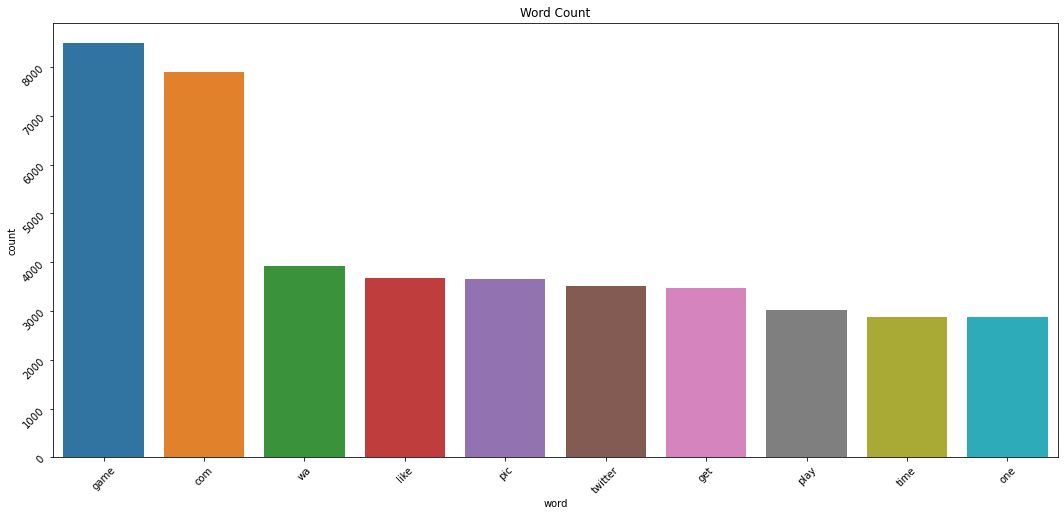

In [81]:
p_df = word_count_df.sort_values(0,ascending=False).iloc[:10].reset_index()
p_df.columns = ['word','count']
fig,ax = plt.subplots(figsize=(18,8))
sns.barplot(data=p_df,x='word',y='count',ax = ax)
plt.title("Word Count")
ax.tick_params(labelrotation=45)
plt.show()
plt.close()

In [73]:
train_df.head()

,i,topic,sentiment,tweet,cleaned_tweet
0,2401,Borderlands,Positive,im getting on borderlands and i will murder yo...,borderland im getting murder
1,2401,Borderlands,Positive,I am coming to the borders and I will kill you...,coming kill border
2,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...,borderland im kill getting
3,2401,Borderlands,Positive,im coming on borderlands and i will murder you...,borderland im coming murder
4,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...,borderland im getting murder


In [60]:
## Wordcloud

In [66]:
def gen_wordcloud(sent_list):
    sent_str = ""
    for sent in sent_list:
        sent_str+=sent+ " "
    return sent_str

In [67]:
train_word_cloud = gen_wordcloud(train_df['cleaned_tweet'])
train_word_cloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = stop_words,
                min_font_size = 10).generate(train_word_cloud)

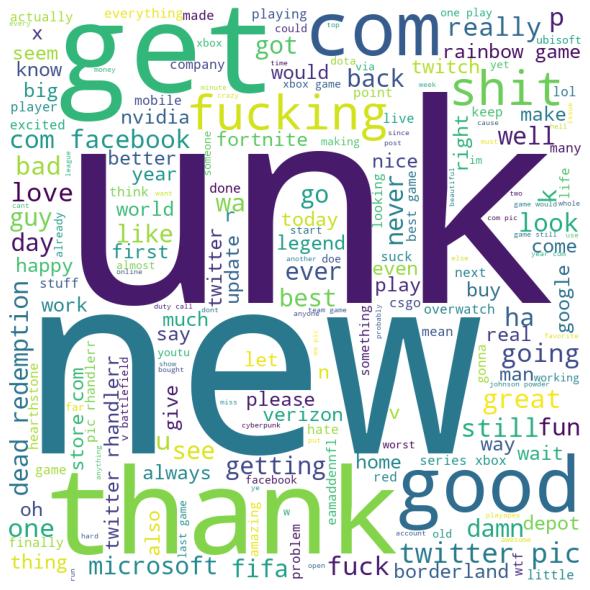

In [68]:
# plot the WordCloud image                      
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(train_word_cloud)
plt.axis("off")
plt.tight_layout(pad = 0)
 
plt.show()

In [69]:
test_word_cloud = gen_wordcloud(test_df['cleaned_tweet'])
test_word_cloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = stop_words,
                min_font_size = 10).generate(test_word_cloud)

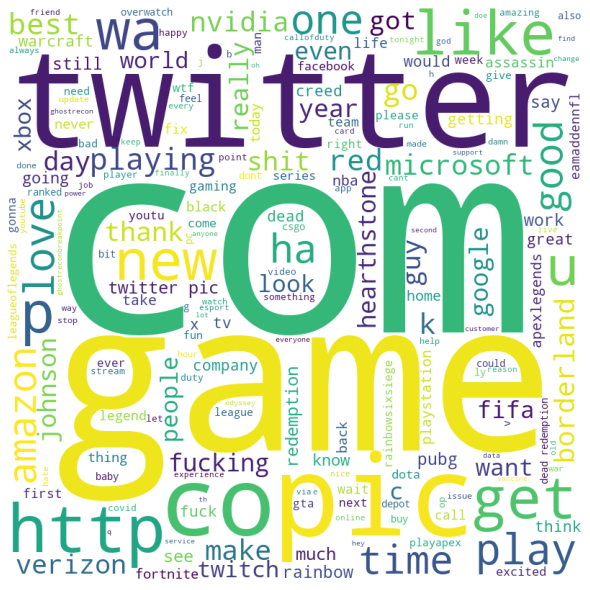

In [70]:
# plot the WordCloud image                      
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(test_word_cloud)
plt.axis("off")
plt.tight_layout(pad = 0)
 
plt.show()